Using an Azure free tier account create an Azure MLOps pipeline with the following steps:

Data Preparation
Train and Validate Model
Evaluate Trained Model
Within the first step of the pipeline you will load the Online Shoppers Purchasing Intention Dataset and perform any appropriate data preparation. This step should be used to split the dataset for the following steps.

The training step should be used to train your Random Forest model on the previously prepared training data. Any configurations or settings for the model are left to your discretion. Keep in mind that this assessment should be able to be completed on the Azure free tier so run time should be kept to a minimum. Prediction accuracy will be taken into account but is not the sole, determining factor of this assessment. This step should output a trained model in pickle format to the next step of the pipeline.

The evaluation step should have two inputs, evaluation data from the first step and the trained model from the second step. Using your trained model predict class label of Revenue for the evaluation data. This step should output the features and predicted label such that the predictions can be scored against the actual data. Using the actuals and predictions, calculate the accuracy, specificity, and sensitivity of the model.

Notes:

There should be no need to incur costs for this assessment. It should be able to be completed with a free tier Azure account.
All information for the dataset can be found here

In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import scipy.stats as stats
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
# Permutation feature importance
from sklearn.inspection import permutation_importance

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score


In [46]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf


def plot_AUC_roc_curve_(y_test, y_pred, classifier, model_name):
    ns_probs = [0 for _  in range(len(y_test))]
    y_pred_prob = classifier.predict_proba(x_test)
    y_pred_prob = y_pred_prob[:,1]
    ns_auc = metrics.roc_auc_score(y_test,ns_probs)

    ns_fpr,ns_tpr, _ = metrics.roc_curve(y_test,ns_probs)
    classifier_fpr,classifier_tpr, _ = metrics.roc_curve(y_test,y_pred_prob)

    nb_roc_auc = metrics.roc_auc_score(y_test,y_pred)

    plt.plot(ns_fpr,ns_tpr,linestyle = '--',color='red')
    plt.plot(classifier_fpr,classifier_tpr,marker='o',color='orange',label= model_name + ' (area = %0.3f)' % nb_roc_auc)
    plt.ylabel('True Positive Rate',size=14)
    plt.xlabel('False Positive Rate',size=14)
    plt.title(model_name + ' AUC-ROC curve',size=18)
    plt.rcParams['axes.spines.right']=True # remove the plot border
    plt.rcParams['axes.spines.left']=True # remove the plot border
    plt.rcParams['axes.spines.top']=True # remove the plot border
    plt.rcParams['axes.spines.bottom']=True #
    plt.legend()
    plt.show()

def costamized_metric(y_test,y_pred, **kwargs):

    my_metric = kwargs['my_metric']

    M= metrics.confusion_matrix(y_test,y_pred)
    TP = M[1,1]
    TN = M[0,0]
    FP = M[0,1]
    FN = M[1,0]

    metric_dic = dict()
    metric_dic['SEN'] = TP/(TP+FN)  # Sensitivity
    metric_dic['SPC'] = TN/(TN+FP)  # Specificity
    metric_dic['PPV'] = TP/(TP+FP)  # Positive Predictive Value
    metric_dic['NPV'] = TN/(TN+FN)  # Negative Predictive Value
    metric_dic['ACCURACY'] = (TP+TN)/((TP+TN+FP+FN))

    if my_metric not in ['SEN','SPC','PPV','NPV', 'ACCURACY','ALL']:
        print('-------'*10)
        print('Wrong metric asked')

    elif my_metric == 'ALL':
        scores = pd.DataFrame()
        scores['Metric'] = [I[0] for I in metric_dic.items()]
        scores['Value']  = [I[1] for I in metric_dic.items()]

    else:
        scores = metric_dic[my_metric]

    return np.round(scores,4)

def plot_confusion_matrix(y_test, y_hat):
    cm=metrics.confusion_matrix(y_test, y_hat)
    cm/np.sum(cm)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{var1}\n{var2}\n{var3}" for var1,var2,var3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(7,5))

    sns.heatmap(cm,
                annot=labels,
                fmt='',
                cmap='coolwarm',
                xticklabels=['Negative or 0','Positive or 1'],
                yticklabels=['Negative or 0','Positive or 1'],
                annot_kws={'size':16})

    plt.title('Confusion Matrix')
    plt.show()


# Load Data:

In [117]:
df = pd.read_csv('/content/online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [119]:
#df.isna().sum()

In [120]:
#df.describe()

In [121]:
df.sample(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
8016,2,21.0,1,802.5,48,2073.916667,0.003922,0.026275,0.0,0.0,Nov,2,2,3,2,Returning_Visitor,True,False
359,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Mar,3,2,1,1,Returning_Visitor,False,False


In [122]:
df.shape

(12330, 18)

In [123]:
df['Revenue'].value_counts(1)*100

,proportion
Revenue,
False,84.525547
True,15.474453


In [124]:
df.duplicated().sum()

125

In [125]:
df.drop_duplicates(inplace=True, keep='first')

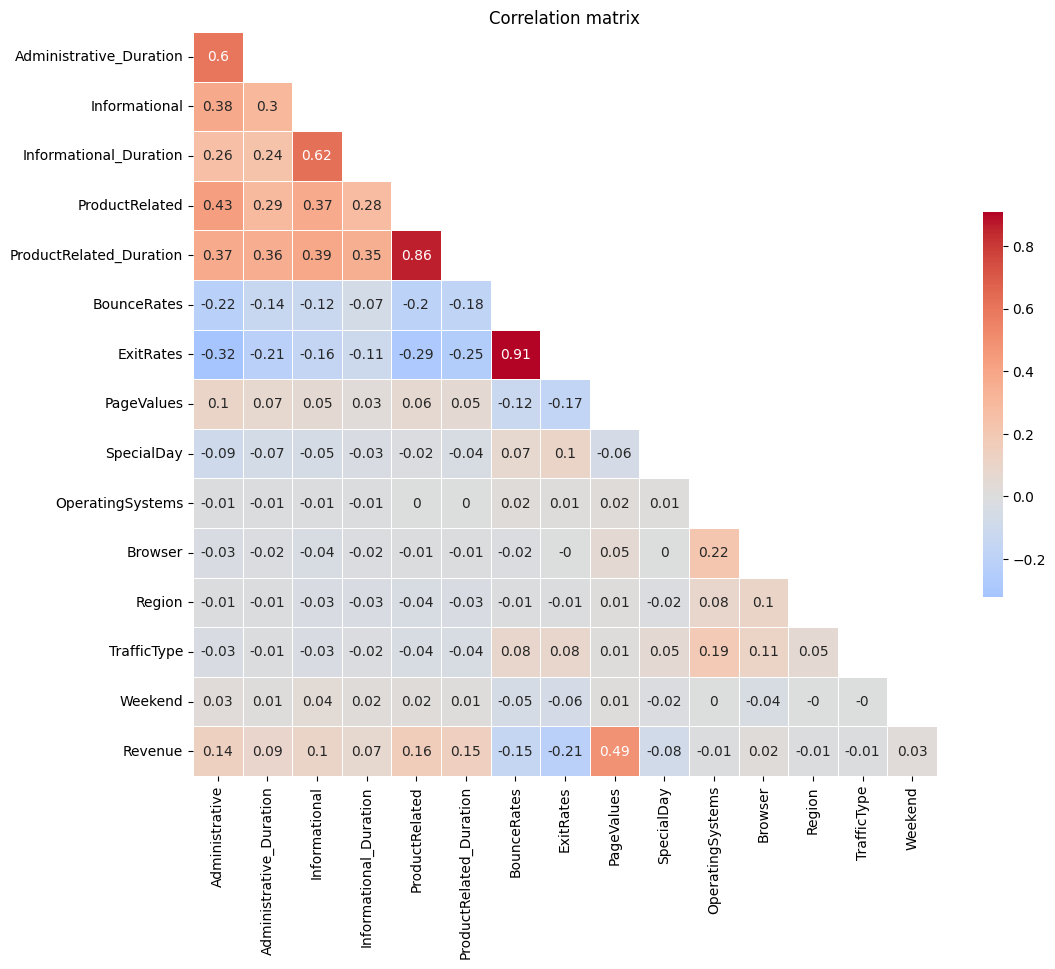

In [12]:
# Moving the Revenue label to the end for better visualisation
cols = [c for c in df if c != 'Revenue'] + ['Revenue']
df = df[cols]

# Correlational Matrix
df_corr_matrix = df[df.select_dtypes(include=['number', 'bool']).columns].corr().round(2)

# Plotting
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(df_corr_matrix))
ax = sns.heatmap(df_corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xlim(0,len(df_corr_matrix)-1)
ax.set_ylim(len(df_corr_matrix),1)
#ax.collections[0].set_clim(-1,1)
plt.title('Correlation matrix')
plt.show()

In [126]:
df.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
12261,5,157.333333,0,0.0,76,3923.586111,0.000866,0.013676,0.0,0.0,Nov,2,2,8,2,Returning_Visitor,True,False
7016,0,0.000000,0,0.0,1,19.200000,0.000000,0.100000,0.0,0.0,Aug,1,1,1,1,Returning_Visitor,True,False
3493,2,256.000000,0,0.0,14,574.500000,0.000000,0.014286,0.0,0.0,May,3,3,8,11,New_Visitor,False,False
6962,3,37.200000,1,0.0,3,14.000000,0.000000,0.033333,0.0,0.0,Sep,2,7,7,2,New_Visitor,True,False
5322,1,77.000000,0,0.0,22,710.666667,0.000000,0.002174,0.0,0.0,May,2,4,3,4,Returning_Visitor,False,False


In [130]:
df['OperatingSystems'].value_counts()

,count
OperatingSystems,
2,6541
1,2549
3,2530
4,478
8,75
6,19
7,7
5,6


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12205 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12205 non-null  int64  
 1   Administrative_Duration  12205 non-null  float64
 2   Informational            12205 non-null  int64  
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  int64  
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  int64  
 12  Browser                  12205 non-null  int64  
 13  Region                   12205 non-null  int64  
 14  TrafficType              12

In [131]:
for col in ['Browser','Region','TrafficType','OperatingSystems']:
    df[col] = df[col].astype('category')

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12205 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           12205 non-null  int64   
 1   Administrative_Duration  12205 non-null  float64 
 2   Informational            12205 non-null  int64   
 3   Informational_Duration   12205 non-null  float64 
 4   ProductRelated           12205 non-null  int64   
 5   ProductRelated_Duration  12205 non-null  float64 
 6   BounceRates              12205 non-null  float64 
 7   ExitRates                12205 non-null  float64 
 8   PageValues               12205 non-null  float64 
 9   SpecialDay               12205 non-null  float64 
 10  Month                    12205 non-null  object  
 11  OperatingSystems         12205 non-null  category
 12  Browser                  12205 non-null  category
 13  Region                   12205 non-null  category
 14  TrafficType

In [133]:
x = df.drop('Revenue',axis=1)
y = df['Revenue']

In [134]:
num_col = x.select_dtypes(include=['number','bool']).columns
num_col
num_col_df = x[num_col]
num_col_df = num_col_df.reset_index(drop=True)
num_col_df = num_col_df.drop('Weekend',axis=1)
num_col_df.head(4)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0


In [135]:
cat_col = x.select_dtypes(include=['object','category']).columns
cat_col = ['Month', 'VisitorType','Weekend','Browser','Region','TrafficType','OperatingSystems']
cat_col

['Month',
 'VisitorType',
 'Weekend',
 'Browser',
 'Region',
 'TrafficType',
 'OperatingSystems']

In [136]:
cat_col_dum = pd.get_dummies(x[cat_col],drop_first=True,dtype=int)
cat_col_dum['Weekend'] = cat_col_dum['Weekend'].astype(int)
cat_col_dum = cat_col_dum.reset_index(drop=True)
cat_col_dum.head(4)

,Weekend,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [137]:
pd.options.display.max_columns = None

In [138]:
#num_col_df.sample(2)

In [150]:
X = pd.concat([num_col_df,cat_col_dum],axis=1)
#X['Weekend'] = X['Weekend'].astype(int)
X.head(4)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [151]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [146]:
x_train.sample(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8
11186,0,0.00,0,0.0,1,0.000000,0.20,0.200000,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9170,0,0.00,0,0.0,10,108.916667,0.02,0.040000,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9147,4,55.25,0,0.0,27,705.500000,0.00,0.007901,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [149]:
cat_col_dum.columns
num_col_df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'],
      dtype='object')

In [27]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42,class_weight='balanced'))
])
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [28]:
pipeline.fit(x_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [59]:
model_performance_classification_sklearn(pipeline,x_train,y_train)

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [60]:
model_performance_classification_sklearn(pipeline,x_test,y_test)

,Accuracy,Recall,Precision,F1
0,0.890105,0.527981,0.738095,0.615603


In [31]:
result = permutation_importance(pipeline, x_train, y_train, n_repeats=10, random_state=0, n_jobs=-1)
feature_names = x_train.columns
perm_imp_df = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)
perm_imp_df

,Feature,Permutation Importance
8,PageValues,0.167599
7,ExitRates,0.053335
5,ProductRelated_Duration,0.041433
6,BounceRates,0.041008
4,ProductRelated,0.035959
21,Month_Nov,0.029765
1,Administrative_Duration,0.027230
0,Administrative,0.023642
12,Region,0.012338
13,TrafficType,0.011212


In [67]:
#pip install shap

In [73]:
#pip install shap
#import shap
from sklearn.model_selection import StratifiedKFold

In [78]:
# Define a grid of hyperparameters to search over
param_distributions = {
    'classifier__n_estimators': [100, 150, 250, 400],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [None, 5, 8, 10],
    'classifier__min_samples_leaf': [ 4, 5, 10],
    'classifier__max_samples': np.linspace(0.1, 0.9, num=8)
}

In [76]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


In [77]:
f1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

In [79]:
params = GridSearchCV(pipeline, param_distributions, scoring=f1_scorer, cv=5, n_jobs=-1)
params.fit(x_train, y_train)
print('Best hyperparameters are:')
params.best_params_

Best hyperparameters are:


{'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__max_samples': 0.44285714285714284,
 'classifier__min_samples_leaf': 4,
 'classifier__n_estimators': 250}

In [80]:
params.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__max_samples': 0.44285714285714284,
 'classifier__min_samples_leaf': 4,
 'classifier__n_estimators': 250}

In [82]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [63]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42,
                                          class_weight='balanced',
                                          max_depth=9,
                                          n_estimators=1400))
])
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=9,
                                        n_estimators=1400, random_state=42))])

In [64]:
pipeline.fit(x_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=9,
                                        n_estimators=1400, random_state=42))])

In [65]:
model_performance_classification_sklearn(pipeline,x_train,y_train)

,Accuracy,Recall,Precision,F1
0,0.898723,0.891116,0.614747,0.72757


In [66]:
model_performance_classification_sklearn(pipeline,x_test,y_test)

,Accuracy,Recall,Precision,F1
0,0.877129,0.805353,0.597473,0.68601


In [67]:
x_train.head(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor
1785,0,0.0,0,0.0,7,95.000000,0.014286,0.061905,0.000000,0.0,2,6,1,1,0,0,0,0,0,1,0,0,0,0,0,1
10407,2,14.0,0,0.0,81,1441.910588,0.002469,0.013933,2.769599,0.0,2,2,3,2,0,0,0,0,0,0,0,1,0,0,0,1


In [68]:
y_pred = pipeline.predict(x_test)
y_pred

array([False,  True,  True, ..., False,  True, False])

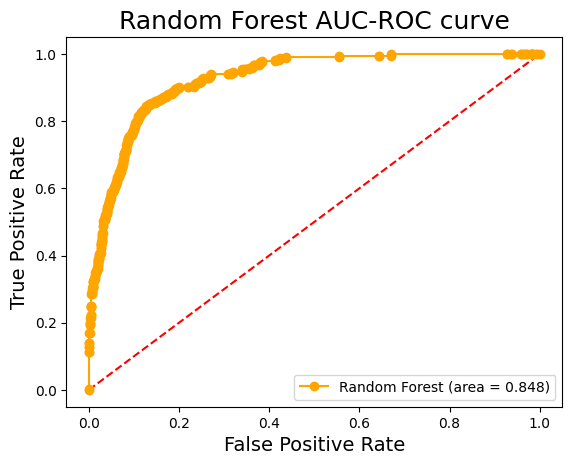

In [69]:
plot_AUC_roc_curve_(y_test,y_pred,pipeline, 'Random Forest')

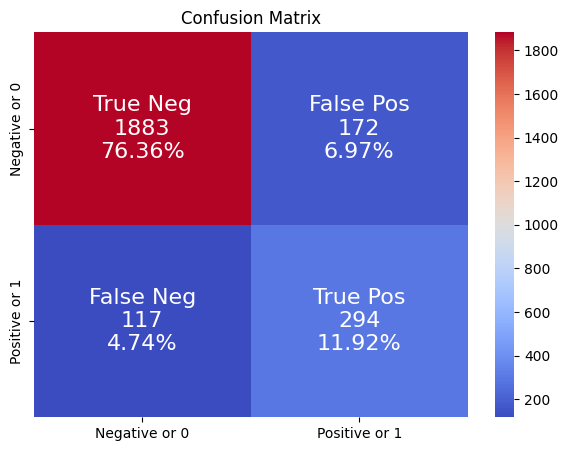

In [62]:
plot_confusion_matrix(y_test,y_pred)

In [155]:
cat_col

['Month',
 'VisitorType',
 'Weekend',
 'Browser',
 'Region',
 'TrafficType',
 'OperatingSystems']

In [161]:
x = df.drop('Revenue',axis=1)
y = df['Revenue']

#x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(x,y, test_size=0.20, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

In [163]:
X_train.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
7556,8,203.6,1,0.0,42,1052.400000,0.0,0.004545,37.357258,0.0,Nov,2,2,5,2,Returning_Visitor,False
11924,0,0.0,0,0.0,30,901.288889,0.0,0.007333,34.148420,0.0,Dec,2,2,7,2,New_Visitor,False
3306,0,0.0,0,0.0,13,421.166667,0.0,0.028205,0.000000,0.8,May,1,1,1,2,Returning_Visitor,False


In [164]:
X_test.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
1554,7,108.666667,6,853.75,194,6737.271825,0.000124,0.006139,0.000000,0.0,Mar,2,5,1,3,Returning_Visitor,True
7772,0,0.000000,0,0.00,42,602.883333,0.000000,0.004365,21.266325,0.0,Sep,6,2,3,1,Returning_Visitor,False
629,0,0.000000,0,0.00,58,3200.366667,0.003448,0.027586,0.000000,0.0,Mar,2,2,6,1,Returning_Visitor,False


In [165]:
# Identify numeric and categorical columns
numeric_features = num_col_df.columns
categorical_features = cat_col


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Scale features
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent category
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical features, ignore unknown categories
])


In [158]:
#categorical_features

In [166]:
# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [233]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('classifier', RandomForestClassifier(random_state=42,
                                          class_weight='balanced',
                                          max_depth=8,
                                          n_estimators=800))
])

pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Month', 'VisitorType',
                                                   'Weekend', 'Browser',
                                                   'Region', 'TrafficType',
                                                   'OperatingSystems'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        n_estimators=800, random_state=42))])

In [234]:
model_performance_classification_sklearn(pipeline,X_train,y_train)

,Accuracy,Recall,Precision,F1
0,0.876485,0.864351,0.569025,0.686264


In [235]:
model_performance_classification_sklearn(pipeline,X_test,y_test)

,Accuracy,Recall,Precision,F1
0,0.86896,0.842932,0.553265,0.66805


In [236]:
y_pred = pipeline.predict(X_test)
y_pred

array([False,  True, False, ...,  True, False, False])

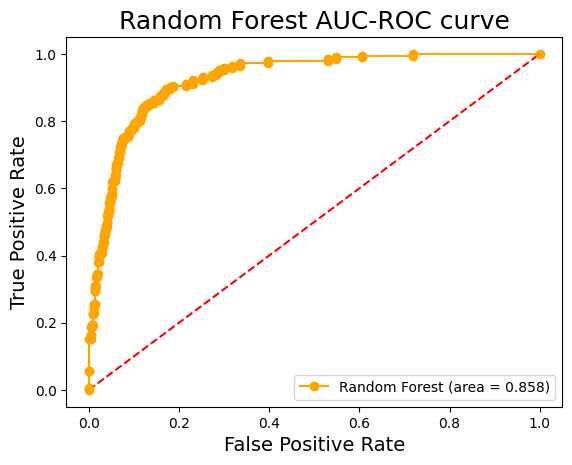

In [237]:
plot_AUC_roc_curve_(y_test,y_pred,pipeline, 'Random Forest')

In [254]:
y_pred_ = pipeline.predict(X_test)
y_pred_

array([False,  True, False, ...,  True, False, False])

In [257]:
costamized_metric(y_test,y_pred,my_metric='ALL')

,Metric,Value
0,SEN,0.8429
1,SPC,0.8738
2,PPV,0.5533
3,NPV,0.9677
4,ACCURACY,0.8690


In [238]:
#5-Fold Cross-Validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation scores (5 folds): {cv_scores}")
print(f"Mean Cross-validation score: {cv_scores.mean():.4f}")

Cross-validation scores (5 folds): [0.86789555 0.86943164 0.86533538 0.87455197 0.86526639]
Mean Cross-validation score: 0.8685


In [178]:
X_train.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend'],
      dtype='object')

In [177]:
transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
print("Transformed feature names:", transformed_feature_names)

Transformed feature names: ['num__Administrative' 'num__Administrative_Duration' 'num__Informational'
 'num__Informational_Duration' 'num__ProductRelated'
 'num__ProductRelated_Duration' 'num__BounceRates' 'num__ExitRates'
 'num__PageValues' 'num__SpecialDay' 'cat__Month_Aug' 'cat__Month_Dec'
 'cat__Month_Feb' 'cat__Month_Jul' 'cat__Month_June' 'cat__Month_Mar'
 'cat__Month_May' 'cat__Month_Nov' 'cat__Month_Oct' 'cat__Month_Sep'
 'cat__VisitorType_New_Visitor' 'cat__VisitorType_Other'
 'cat__VisitorType_Returning_Visitor' 'cat__Weekend_False'
 'cat__Weekend_True' 'cat__Browser_1' 'cat__Browser_2' 'cat__Browser_3'
 'cat__Browser_4' 'cat__Browser_5' 'cat__Browser_6' 'cat__Browser_7'
 'cat__Browser_8' 'cat__Browser_9' 'cat__Browser_10' 'cat__Browser_11'
 'cat__Browser_12' 'cat__Browser_13' 'cat__Region_1' 'cat__Region_2'
 'cat__Region_3' 'cat__Region_4' 'cat__Region_5' 'cat__Region_6'
 'cat__Region_7' 'cat__Region_8' 'cat__Region_9' 'cat__TrafficType_1'
 'cat__TrafficType_2' 'cat__Traffic

In [180]:
len(transformed_feature_names)

74

In [179]:
X_valid_transformed = pipeline.named_steps['preprocessor'].transform(X_valid)
print("Transformed validation data shape:", X_valid_transformed.shape)

Transformed validation data shape: (1220, 74)


# Feature Importance:

In [181]:
model = pipeline.named_steps['classifier']  # Access the classifier
feature_importances = model.feature_importances_
feature_importances

array([3.26836815e-02, 3.44930743e-02, 9.17955945e-03, 1.24955152e-02,
       5.29640239e-02, 7.14360770e-02, 4.52888682e-02, 9.70203639e-02,
       4.72045855e-01, 8.43172661e-03, 1.46041088e-03, 3.00232535e-03,
       9.44253232e-04, 2.00293797e-03, 9.34290610e-04, 7.61352706e-03,
       1.11311430e-02, 3.52246737e-02, 4.29699172e-03, 2.83353055e-03,
       9.92527842e-03, 2.92798739e-04, 1.03606700e-02, 2.45582373e-03,
       2.51413116e-03, 1.51309951e-03, 2.17876341e-03, 3.90029758e-04,
       1.59043245e-03, 9.74432193e-04, 6.40073802e-04, 1.78832625e-04,
       5.83698901e-04, 1.42903892e-06, 6.35557942e-04, 3.00796833e-05,
       5.08454319e-04, 4.61728343e-04, 2.29481695e-03, 1.74880549e-03,
       2.27084239e-03, 1.67054874e-03, 8.89158095e-04, 1.25305303e-03,
       1.18528669e-03, 1.39127320e-03, 1.09297970e-03, 4.19128050e-03,
       9.39418339e-03, 5.90767791e-03, 1.62049735e-03, 1.42315741e-03,
       1.03159058e-03, 3.29579604e-04, 2.28161156e-03, 1.21968632e-04,
      

In [182]:
numeric_features = pipeline.named_steps['preprocessor'].transformers_[0][2]
numeric_feature_names = list(numeric_features)
numeric_feature_names

['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay']

In [187]:
categorical_encoder = preprocessor.transformers_[1][1].named_steps['onehot']
categorical_feature_names = categorical_encoder.get_feature_names_out(input_features=categorical_features).tolist()
all_feature_names = numeric_feature_names + categorical_feature_names

In [191]:
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})
feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
8,PageValues,0.472046
7,ExitRates,0.097020
5,ProductRelated_Duration,0.071436
4,ProductRelated,0.052964
6,BounceRates,0.045289
17,Month_Nov,0.035225
1,Administrative_Duration,0.034493
0,Administrative,0.032684
3,Informational_Duration,0.012496
16,Month_May,0.011131


In [197]:
prob_pos = pipeline.predict_proba(X_valid)[:, 1]
prob_pos

array([0.81685373, 0.39255487, 0.25856837, ..., 0.36912369, 0.31822841,
       0.14186466])

## Save the final Model:

In [241]:
import pickle

# Save the model to a file
model_filename = "rf_shoppers_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(pipeline, file)

print(f"Model saved to:  {model_filename}")

Model saved to:  rf_shoppers_model.pkl


In [243]:
X_test.to_csv('X_test.csv',index=False)

In [245]:
new_data = pd.read_csv('X_test.csv')
new_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,7,108.666667,6,853.75,194,6737.271825,0.000124,0.006139,0.000000,0.0,Mar,2,5,1,3,Returning_Visitor,True
1,0,0.000000,0,0.00,42,602.883333,0.000000,0.004365,21.266325,0.0,Sep,6,2,3,1,Returning_Visitor,False
2,0,0.000000,0,0.00,58,3200.366667,0.003448,0.027586,0.000000,0.0,Mar,2,2,6,1,Returning_Visitor,False
3,0,0.000000,0,0.00,9,250.500000,0.000000,0.044444,0.000000,0.0,Mar,3,2,7,1,Returning_Visitor,True
4,5,141.000000,0,0.00,33,1371.633333,0.000000,0.005556,44.711034,0.0,Mar,2,4,3,8,New_Visitor,True


In [244]:
sp_model = pickle.load(open(model_filename, 'rb'))

In [248]:
predictions = sp_model.predict_proba(new_data)[:, 1]
predictions

array([0.33473313, 0.75659729, 0.23256027, ..., 0.83237908, 0.09437948,
       0.12322015])

In [250]:
pred = sp_model.predict(new_data).astype(int)
pred

array([0, 1, 0, ..., 1, 0, 0])

In [251]:
output = new_data.copy()
output['predictions'] = predictions
output['Flag'] = pred
output.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,predictions,Flag
0,7,108.666667,6,853.75,194,6737.271825,0.000124,0.006139,0.000000,0.0,Mar,2,5,1,3,Returning_Visitor,True,0.334733,0
1,0,0.000000,0,0.00,42,602.883333,0.000000,0.004365,21.266325,0.0,Sep,6,2,3,1,Returning_Visitor,False,0.756597,1
2,0,0.000000,0,0.00,58,3200.366667,0.003448,0.027586,0.000000,0.0,Mar,2,2,6,1,Returning_Visitor,False,0.232560,0
3,0,0.000000,0,0.00,9,250.500000,0.000000,0.044444,0.000000,0.0,Mar,3,2,7,1,Returning_Visitor,True,0.088075,0
4,5,141.000000,0,0.00,33,1371.633333,0.000000,0.005556,44.711034,0.0,Mar,2,4,3,8,New_Visitor,True,0.802708,1


In [253]:
output.to_csv('prediction_output.csv',index=False)

# Model Calibration:

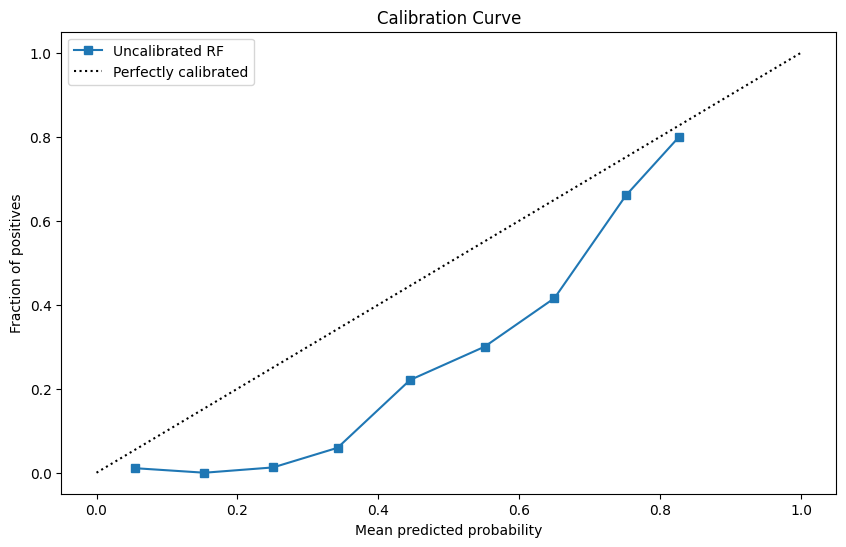

In [199]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_valid, prob_pos, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Uncalibrated RF')
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")  # Diagonal line for perfectly calibrated
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()

In [200]:
brier_score = brier_score_loss(y_valid, prob_pos)
print(f"Brier Score (Uncalibrated): {brier_score:.4f}")

Brier Score (Uncalibrated): 0.1157


In [203]:
calibrated_model = CalibratedClassifierCV(pipeline, method='isotonic', cv='prefit')
calibrated_model.fit(X_valid, y_valid)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('preprocessor',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRa...
      dtype='object')),
                                                                                  ('cat',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('onehot',
                                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                                   ['Month',
                                                                                    'VisitorType',
                                                                                    'Weekend',
                                                                                    'Browser',
                                                                                    'Region',
                                                                                    'TrafficType',
                                                                                    'OperatingSystems'])])),
                                                 ('classifier',
                                                  RandomForestClassifier(class_weight='balanced',
                                                                         max_depth=8,
                                                                         n_estimators=800,
                                                                         random_state=42))]),
                       method='isotonic')

In [206]:
prob_pos_calibrated = calibrated_model.predict_proba(X_valid)[:, 1]
prob_pos_calibrated

array([0.75      , 0.13131313, 0.01507538, ..., 0.13131313, 0.02631579,
       0.00576369])

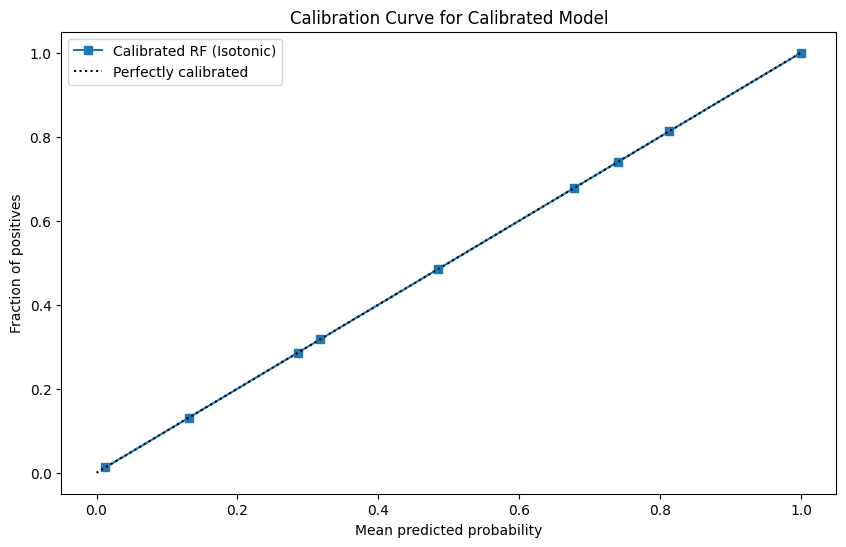

In [207]:
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(y_valid, prob_pos_calibrated, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, "s-", label='Calibrated RF (Isotonic)')
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted probability")
plt.title("Calibration Curve for Calibrated Model")
plt.legend()
plt.show()

In [208]:
brier_score_calibrated = brier_score_loss(y_valid, prob_pos_calibrated)
print(f"Brier Score (Calibrated): {brier_score_calibrated:.4f}")

Brier Score (Calibrated): 0.0716


In [209]:
prob_pos_test_uncalibrated = pipeline.predict_proba(X_test)[:, 1]  # Uncalibrated probabilities
prob_pos_test_calibrated = calibrated_model.predict_proba(X_test)[:, 1]  # Calibrated probabilities

In [210]:
prob_pos_test_uncalibrated

array([0.33473313, 0.75659729, 0.23256027, ..., 0.83237908, 0.09437948,
       0.12322015])

In [211]:
prob_pos_test_calibrated

array([0.04395604, 0.72413793, 0.01507538, ..., 0.8125    , 0.00576369,
       0.00576369])

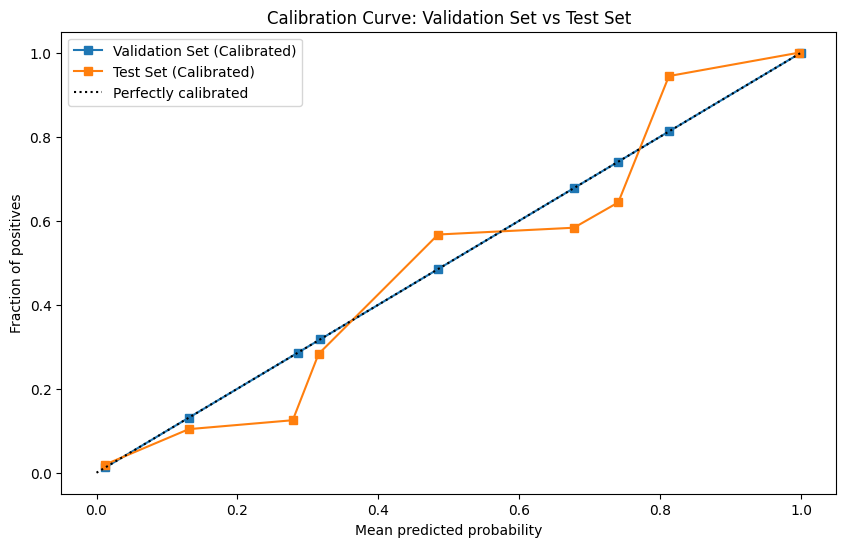

In [214]:
prob_pos_valid_uncalibrated = pipeline.predict_proba(X_valid)[:, 1]  # Uncalibrated probabilities
prob_pos_valid_calibrated = calibrated_model.predict_proba(X_valid)[:, 1]  # Calibrated probabilities

fraction_of_positives_valid, mean_predicted_value_valid = calibration_curve(y_valid, prob_pos_valid_calibrated, n_bins=10)

fraction_of_positives_test, mean_predicted_value_test = calibration_curve(y_test, prob_pos_test_calibrated, n_bins=10)


plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value_valid, fraction_of_positives_valid, "s-", label='Validation Set (Calibrated)')
plt.plot(mean_predicted_value_test, fraction_of_positives_test, "s-", label='Test Set (Calibrated)')
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")  # Diagonal line for perfect calibration
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted probability")
plt.title("Calibration Curve: Validation Set vs Test Set")
plt.legend()
plt.show()

In [215]:
accuracy_valid_calibrated = accuracy_score(y_valid, calibrated_model.predict(X_valid))
accuracy_test_calibrated = accuracy_score(y_test, calibrated_model.predict(X_test))
roc_auc_valid_calibrated = roc_auc_score(y_valid, prob_pos_valid_calibrated)
roc_auc_test_calibrated = roc_auc_score(y_test, prob_pos_test_calibrated)


In [216]:
accuracy_valid_calibrated

0.8967213114754098

In [217]:
accuracy_test_calibrated

0.8886158886158886

In [218]:
roc_auc_valid_calibrated

0.9300138903729032

In [219]:
roc_auc_test_calibrated

0.9229883596807807

In [220]:
brier_score_valid_calibrated = brier_score_loss(y_valid, prob_pos_valid_calibrated)
brier_score_test_calibrated = brier_score_loss(y_test, prob_pos_test_calibrated)

In [221]:
brier_score_valid_calibrated

0.07157272046158804

In [222]:
brier_score_test_calibrated

0.07485682808047797

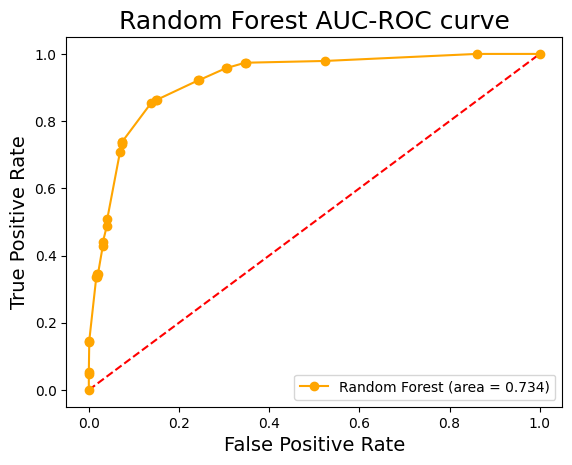

In [228]:
def plot_AUC_roc_curve_(y_test, y_pred, classifier, model_name):
    ns_probs = [0 for _  in range(len(y_test))]
    y_pred_prob = classifier.predict_proba(X_test)
    y_pred_prob = y_pred_prob[:,1]
    ns_auc = metrics.roc_auc_score(y_test,ns_probs)

    ns_fpr,ns_tpr, _ = metrics.roc_curve(y_test,ns_probs)
    classifier_fpr,classifier_tpr, _ = metrics.roc_curve(y_test,y_pred_prob)

    nb_roc_auc = metrics.roc_auc_score(y_test,y_pred)

    plt.plot(ns_fpr,ns_tpr,linestyle = '--',color='red')
    plt.plot(classifier_fpr,classifier_tpr,marker='o',color='orange',label= model_name + ' (area = %0.3f)' % nb_roc_auc)
    plt.ylabel('True Positive Rate',size=14)
    plt.xlabel('False Positive Rate',size=14)
    plt.title(model_name + ' AUC-ROC curve',size=18)
    plt.rcParams['axes.spines.right']=True # remove the plot border
    plt.rcParams['axes.spines.left']=True # remove the plot border
    plt.rcParams['axes.spines.top']=True # remove the plot border
    plt.rcParams['axes.spines.bottom']=True #
    plt.legend()
    plt.show()

y_pred = calibrated_model.predict(X_test)
y_pred
plot_AUC_roc_curve_(y_test,y_pred,calibrated_model, 'Random Forest')

In [229]:
model_performance_classification_sklearn(calibrated_model,X_test,y_test)

,Accuracy,Recall,Precision,F1
0,0.888616,0.507853,0.697842,0.587879


In [231]:
model_performance_classification_sklearn(calibrated_model,X_train,y_train)

,Accuracy,Recall,Precision,F1
0,0.920422,0.625819,0.822567,0.71083


# Feature Engineering: